In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/HME/Temporal-Transformer

/content/drive/MyDrive/HME/Temporal-Transformer


In [3]:
# import the dataloder with ground truth
%run main/data_generator.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HME/Temporal-Transformer
136
dividing data......
[array([['S6', 'Discussion 1.54138969', 'frame_1.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_21.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_41.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_61.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_81.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_101.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_121.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_141.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_161.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_181.jpg']], dtype='<U21'), array([['S6', 'Discussion 1.54138969', 'frame_201.jpg']], dtype='<U21'), a

In [ ]:
# genrate the data
import numpy as np

data = np.load('trainingdata.npy', allow_pickle=True)
dataloader = Dataloader_zzx_central_hm36_gt_tag(data, batch_size=512)
for i, central, gt_3d, cams, name in dataloader.generator():
    break

central_pose_and_shape = np.squeeze(central)
gt_3d = np.squeeze(gt_3d)
central_cams = np.squeeze(cams)


print(i.shape)
print('the dimension for hm36 3d gt is:  ',gt_3d.shape)
print('the dimension for pose_and_shape is:  ',central_pose_and_shape.shape)
print('the dimension for cams is:  ',central_cams.shape)

theta = np.concatenate((central_cams, central_pose_and_shape), axis=1)
print('the dimension for theta is:  ',theta.shape)      # expect to be (512, 85)

dividing data......
torch.Size([512, 8, 82])
the dimension for hm36 3d gt is:   torch.Size([512, 17, 3])
the dimension for pose_and_shape is:   torch.Size([512, 82])
the dimension for cams is:   torch.Size([512, 3])
the dimension for theta is:   (512, 85)


In [25]:
import os
import sys
import pdb
import h5py
import numpy as np
import tensorflow as tf
from main.smpl import Smpl
from main import model_util

import pandas as pd
import matplotlib.pyplot as plt

***** LOGDIR*****:   /data/ssd1/russales/logs/06122021-230334


In [ ]:
# file_path = '/content/drive/MyDrive/HME/Temporal-Transformer/main/models/neutral_smpl_coco_regressor.pkl'
# with open(file_path, 'rb') as f:

#     print(1)

In [ ]:
# initialize the smpl funciton

smpl=Smpl()

In [ ]:
%run main/transformation.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HME/Temporal-Transformer
     |████████████████████████████████| 639 kB 5.1 MB/s 
***** LOGDIR*****:   /data/ssd1/russales/logs/05122021-222511


In [ ]:
central_pose_and_shape = central_pose_and_shape.numpy()
central_pose_and_shape = tf.convert_to_tensor(central_pose_and_shape)
vertices, kp3d_pred, shapes = smpl2vertices(central_pose_and_shape)

In [ ]:
# convert the predicted theta to 3d

# def _compute_output(smpl, theta, **kwargs): #theta=[batchsize,1,85] is the output of one iteration
#         cams = theta[:, :3]     # NUM_CAMERA_PARAMS=3,在列之前的是cams parameters
#         pose_and_shape = theta[:, 3:]   # behind that row are pose and shapes
#         vertices, joints_3d, rotations = smpl(pose_and_shape, **kwargs)    # transform the pose and shape parameter to SMPL vertices
#         joints_2d = model_util.batch_orthographic_projection(joints_3d, cams)
#         shapes = theta[:, -10:] # NUM_SHAPE_PARAMS = 10


#         # '''debug here'''
#         # import pdb # don't know what this is for
#         # pdb.set_trace()

#         return tf.tuple([vertices, joints_2d, joints_3d, rotations, shapes, cams])

# #May need correct about"self""
# vertices, kp2d_pred, kp3d_pred, rotations, shapes, cams =_compute_output(smpl, theta)
    

In [17]:
# video path
# path = '/content/drive/MyDrive/HME/Temporal-Transformer/vertices/vertices.S6.Greeting 1.58860488_resultsgt.npy'
path = '/content/drive/MyDrive/HME/Temporal-Transformer/vertices.S6.Sitting 1.58860488_resultsgt.npy'
data = np.load(path, allow_pickle=True)
kp3d_pred = data.item()['3d'][25]

kp3d_pred = np.expand_dims(kp3d_pred, axis = 0)
gt_3d = data.item()['gt_3d'][25]
gt_3d = np.expand_dims(gt_3d, axis = 0)
print(kp3d_pred.shape)

print(gt_3d.shape)



(1, 19, 3)
(1, 19, 3)


In [18]:

print(kp3d_pred.shape)
# print(kp2d_pred.shape)
print(gt_3d.shape)


(1, 19, 3)
(1, 19, 3)


In [12]:
def hmrmap(data):
  #Reduce 21 to 14 joints
  joint = np.zeros((14,3))
  total = [1,2,3,4,5,6,8,9,10,11,12,13,14,15]
  count = 0
  for i in total:
    joint[count] = data[i]
    count += 1
  return joint

In [13]:
def cocomap(data, batch_size = 512):
  #Reduce 19 to 14 joints
  joint = np.zeros((batch_size, 14,3))
  total = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
  count = 0
  for i in total:
    joint[:,count] = data[:,i]
    count += 1
  return joint

def gtmap(data, batch_size=512):
  #Reduce 17 to 14 joints
  joint = np.zeros((batch_size, 14,3))
  total = [3,2,1,4,5,6, 16,15,14,11,12,13,9,10]
  count = 0
  for i in total:
    joint[:, count] = data[:, i]
    count += 1
  return joint


In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np


def compute_similarity_transform(S1, S2):
    '''
    Computes a similarity transform (sR, t) that takes
    a set of 3D points S1 (3 x N) closest to a set of 3D points S2,
    where R is an 3x3 rotation matrix, t 3x1 translation, s scale.
    i.e. solves the orthogonal Procrutes problem.
    '''
    transposed = False
    if S1.shape[0] != 3 and S1.shape[0] != 2:
        S1 = S1.T
        S2 = S2.T
        transposed = True
    assert(S2.shape[1] == S1.shape[1])

    # 1. Remove mean.
    mu1 = S1.mean(axis=1, keepdims=True)
    mu2 = S2.mean(axis=1, keepdims=True)
    X1 = S1 - mu1
    X2 = S2 - mu2

    # 2. Compute variance of X1 used for scale.
    var1 = np.sum(X1**2)

    # 3. The outer product of X1 and X2.
    K = X1.dot(X2.T)

    # 4. Solution that Maximizes trace(R'K) is R=U*V', where U, V are
    # singular vectors of K.
    U, s, Vh = np.linalg.svd(K)
    V = Vh.T
    # Construct Z that fixes the orientation of R to get det(R)=1.
    Z = np.eye(U.shape[0])
    Z[-1, -1] *= np.sign(np.linalg.det(U.dot(V.T)))
    # Construct R.
    R = V.dot(Z.dot(U.T))

    # 5. Recover scale.
    scale = np.trace(R.dot(K)) / var1

    # 6. Recover translation.
    t = mu2 - scale*(R.dot(mu1))

    # 7. Error:
    S1_hat = scale*R.dot(S1) + t

    if transposed:
        S1_hat = S1_hat.T

    return S1_hat


def align_by_pelvis(joints, get_pelvis=False):
    """
    Assumes joints is 14 x 3 in LSP order.
    Then hips are: [3, 2]
    Takes mid point of these points, then subtracts it.
    """
    left_id = 3
    right_id = 2

    pelvis = (joints[left_id, :] + joints[right_id, :]) / 2.
    if get_pelvis:
        return joints - np.expand_dims(pelvis, axis=0), pelvis
    else:
        return joints - np.expand_dims(pelvis, axis=0)


def compute_errors(gt3ds, preds):
    """
    Gets MPJPE after pelvis alignment + MPJPE after Procrustes.
    Evaluates on the 14 common joints.
    Inputs:
      - gt3ds: N x 14 x 3
      - preds: N x 14 x 3
    """
    errors, errors_pa = [], []
    for i, (gt3d, pred) in enumerate(zip(gt3ds, preds)):
        gt3d = gt3d.reshape(-1, 3)
        # Root align.
        gt3d = align_by_pelvis(gt3d)
        pred3d = align_by_pelvis(pred)

        joint_error = np.sqrt(np.sum((gt3d - pred3d)**2, axis=1))
        errors.append(np.mean(joint_error))

        # Get PA error.
        pred3d_sym = compute_similarity_transform(pred3d, gt3d)
        pa_error = np.sqrt(np.sum((gt3d - pred3d_sym)**2, axis=1))
        errors_pa.append(np.mean(pa_error))

    return errors, errors_pa

In [21]:
## regress the 19 -> 14
joint_3d = cocomap(kp3d_pred)
print(joint_3d.shape)

gt_3d = gt_3d.numpy()
print(gt_3d.shape)
joint_gt_3d = gtmap(gt_3d)

print(joint_gt_3d.shape)


(512, 14, 3)
(1, 19, 3)
(512, 14, 3)


In [23]:
def batch_align_by_pelvis(kp3d):
    """Assumes kp3d is [batch x 17 x 3] in human3.6m order. Then hips are id [1, 4].
       take away [0]and [7],only 15 joints left,so  hips are id [0, 3].
       Takes mid point of these points, then subtracts it.
    Args:
        kp3d: [batch x K x 3]
    Returns:
        aligned_kp3d: [batch x K x 3]
    """
    left_id, right_id = 3, 0
    pelvis = (kp3d[:, left_id, :] + kp3d[:, right_id, :]) / 2.
    return kp3d - tf.expand_dims(pelvis, axis=1)

def batch_compute_similarity_transform(real_kp3d, pred_kp3d):
    """Computes a similarity transform (sR, trans) that takes
        a set of 3D points S1 (3 x N) closest to a set of 3D points S2,
        where R is an 3x3 rotation matrix, trans 3x1 translation, u scale.
        i.e. solves the orthogonal Procrustes problem.
    Args:
        real_kp3d: [batch x K x 3]
        pred_kp3d: [batch x K x 3]
    Returns:
        aligned_kp3d: [batch x K x 3]
    """
    # transpose to [batch x 3 x K]
    real_kp3d = tf.transpose(real_kp3d, perm=[0, 2, 1])
    pred_kp3d = tf.transpose(pred_kp3d, perm=[0, 2, 1])

    # 1. Remove mean.
    mean_real = tf.reduce_mean(real_kp3d, axis=2, keepdims=True)
    mean_pred = tf.reduce_mean(pred_kp3d, axis=2, keepdims=True)

    centered_real = real_kp3d - mean_real
    centered_pred = pred_kp3d - mean_pred

    # 2. Compute variance of centered_real used for scale.
    variance = tf.reduce_sum(centered_pred ** 2, axis=[-2, -1], keepdims=True)

    # 3. The outer product of centered_real and centered_pred.
    K = tf.matmul(centered_pred, centered_real, transpose_b=True)

    # 4. Solution that Maximizes trace(R'K) is R=s*V', where s, V are
    # singular vectors of K.
    with tf.device('/CPU:0'):
        # SVD is terrifyingly slow on GPUs, use cpus for this. Makes it a lot faster.
        s, u, v = tf.linalg.svd(K, full_matrices=True)

        # Construct identity that fixes the orientation of R to get det(R)=1.
        det = tf.sign(tf.linalg.det(tf.matmul(u, v, transpose_b=True)))

    det = tf.expand_dims(tf.expand_dims(det, -1), -1)
    shape = tf.shape(u)
    identity = tf.eye(shape[1], batch_shape=[shape[0]])
    identity = identity * det

    # Construct R.
    R = tf.matmul(v, tf.matmul(identity, u, transpose_b=True))

    # 5. Recover scale.
    trace = tf.linalg.trace(tf.matmul(R, K))
    trace = tf.expand_dims(tf.expand_dims(trace, -1), -1)
    scale = trace / variance

    # 6. Recover translation.
    trans = mean_real - scale * tf.matmul(R, mean_pred)

    # 7. Align
    aligned_kp3d = scale * tf.matmul(R, pred_kp3d) + trans

    return tf.transpose(aligned_kp3d, perm=[0, 2, 1])

In [26]:
# align by pelvis and transformation

gt3d = batch_align_by_pelvis(joint_gt_3d)
kp3d = batch_align_by_pelvis(joint_3d)
# kp3d = torch.from_numpy(kp3d)
# gt3d = torch.from_numpy(gt3d)
kp3d = tf.cast(kp3d, float)
gt3d = tf.cast(gt3d, float)

kp3d_sym = batch_compute_similarity_transform(gt3d, kp3d)

print(kp3d_sym.shape)

(512, 14, 3)


In [27]:
def corModel_Print(data):
  x = []
  y = []
  z = []
  for a in range(0,13):
    x.append(data[a,0])
    y.append(data[a,1])
    z.append(data[a,2])
  minx = min(x)
  maxx = max(x)
  miny = min(y)
  maxy = max(y)
  minz = min(z)
  maxz = max(z)
  
  xlen = maxx-minx 
  ylen = maxx-miny
  zlen = maxz-minz
  maxlen = max(xlen,ylen,zlen)*1.1

  rleg = [0,1,2]
  lleg = [3,4,5]
  body = [12,13]
  larm = [9,10,11]
  rarm= [6,7,8]

  rlegx =[]
  rlegy =[]
  rlegz =[]
  llegx = []
  llegy = []
  llegz =[]
  bodyx = []
  bodyy= []
  bodyz =[]
  larmx = []
  larmy = []
  larmz = []
  rarmx = []
  rarmy = []
  rarmz = []
  
  def jointmap(x,y,z,index,data):
    for a in index:
      x.append(data[a,0])
      y.append(data[a,1])
      z.append(data[a,2])

  jointmap(rlegx, rlegy, rlegz, rleg,data)
  jointmap(llegx, llegy, llegz, lleg,data)
  jointmap(bodyx, bodyy, bodyz, body,data)
  jointmap(larmx,larmy,larmz, larm,data)
  jointmap(rarmx, rarmy, rarmz, rarm,data)

  f = plt.figure(figsize=(2, 2), dpi=150)
  ax = plt.axes(projection='3d')
  plt.xlim((maxx+minx-maxlen)/2, (maxx+minx+maxlen)/2)
  plt.ylim((maxy+miny-maxlen)/2, (maxy+miny+maxlen)/2)
  ax.set_zlim((maxz+minz-maxlen)/2, (maxz+minz+maxlen)/2)
  ax.plot3D(rlegx,rlegy,rlegz, 'b')
  ax.plot3D(llegx,llegy,llegz, 'r')
  ax.plot3D(bodyx,bodyy,bodyz, 'g')
  ax.plot3D(rarmx,rarmy,rarmz, 'b')
  ax.plot3D(larmx,larmy,larmz, 'r')
  plt.axis('off')
  return ax

In [ ]:
print(vertices.shape)
np.save('hmr_vertices', vertices[400])

(512, 6890, 3)


tf.Tensor(
[[[ 0.19515055 -0.00307353 -0.1412699 ]
  [ 0.2066193  -0.17498258 -0.06388158]
  [ 0.31492454 -0.18255109  0.06700548]
  ...
  [ 0.12187785 -0.16505754  0.06760496]
  [ 0.2135026  -0.32938138  0.14758885]
  [ 0.15733689 -0.39339155  0.14006774]]

 [[ 0.19515055 -0.00307353 -0.1412699 ]
  [ 0.2066193  -0.17498258 -0.06388158]
  [ 0.31492454 -0.18255109  0.06700548]
  ...
  [ 0.12187785 -0.16505754  0.06760496]
  [ 0.2135026  -0.32938138  0.14758885]
  [ 0.15733689 -0.39339155  0.14006774]]

 [[ 0.19515055 -0.00307353 -0.1412699 ]
  [ 0.2066193  -0.17498258 -0.06388158]
  [ 0.31492454 -0.18255109  0.06700548]
  ...
  [ 0.12187785 -0.16505754  0.06760496]
  [ 0.2135026  -0.32938138  0.14758885]
  [ 0.15733689 -0.39339155  0.14006774]]

 ...

 [[ 0.19515055 -0.00307353 -0.1412699 ]
  [ 0.2066193  -0.17498258 -0.06388158]
  [ 0.31492454 -0.18255109  0.06700548]
  ...
  [ 0.12187785 -0.16505754  0.06760496]
  [ 0.2135026  -0.32938138  0.14758885]
  [ 0.15733689 -0.39339155  0.140

[['S5' 'SittingDown 1.58860488' 'frame_461.jpg']]


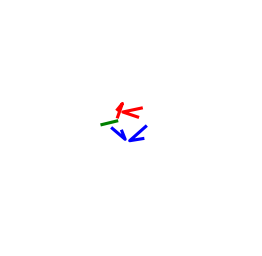

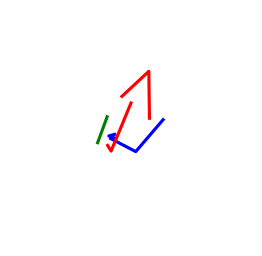

In [30]:
plots = []
plots.append(corModel_Print(kp3d_sym[2]))
plots.append(corModel_Print(gt3d[2]))

print(name[323])

In [ ]:
def loss_3d(kp3d_sym, gt3d):
    kp3d_mpjpe_aligned = tf.norm(kp3d_sym - gt3d, axis=2)
    kp3d_mpjpe_aligned = tf.reduce_mean(kp3d_mpjpe_aligned)
    # kp3d_mpjpe_aligned = torch.norm(kp3d_sym - gt3d, dim=2)
    # kp3d_mpjpe_aligned = torch.reduce_mean(kp3d_mpjpe_aligned)
    return kp3d_mpjpe_aligned

# loss = loss_3d(kp3d_sym, gt3d)
# print(loss)

In [ ]:
def loss_compute(pred, central, gt3d):
    loss1 = torch.mean(torch.norm((pred.squeeze() - central.squeeze()), dim = 1))

    pred = np.squeeze(pred)
    gt3d = np.squeeze(gt3d)
    
    pred = pred.numpy()
    pred = tf.convert_to_tensor(pred)
    vertices, kp3d_pred, shapes = smpl2vertices(pred)

    joint_3d = cocomap(kp3d_pred)
    # print(joint_3d.shape)

    gt_3d = gt3d.numpy()
    # print(gt_3d.shape)
    joint_gt_3d = gtmap(gt_3d)

    # print(joint_gt_3d.shape)
    gt3d = batch_align_by_pelvis(joint_gt_3d)
    kp3d = batch_align_by_pelvis(joint_3d)
    # kp3d = torch.from_numpy(kp3d)
    # gt3d = torch.from_numpy(gt3d)
    kp3d = tf.cast(kp3d, float)
    gt3d = tf.cast(gt3d, float)

    kp3d_sym = batch_compute_similarity_transform(gt3d, kp3d)

    loss2 = loss_3d(kp3d_sym, gt3d)

    loss = loss1 + 10 * loss2
    print(" The total loss is: ", loss, '\n', 'The smpl loss is: ', loss1, '\n', 'The 3D joints loss is: ', loss2)
    print(type(loss2))
    return

loss_compute(central, central, gt_3d)


 The total loss is:  tensor(1.5449) 
 The smpl loss is:  tensor(0.) 
 The 3D joints loss is:  tensor(0.1545)
<class 'torch.Tensor'>


In [ ]:
def hmrmodel_Print(data):
  x = []
  y = []
  z = []
  # for a in range(0,20):     
  for a in range(0,18):       # switch to the upper line when we can produce 21
    x.append(data[a,0])
    y.append(data[a,1])
    z.append(data[a,2])
  minx = min(x)
  maxx = max(x)
  miny = min(y)
  maxy = max(y)
  minz = min(z)
  maxz = max(z)
  
  xlen = maxx-minx 
  ylen = maxx-miny
  zlen = maxz-minz
  maxlen = max(xlen,ylen,zlen)*1.1

  rleg = [1, 2, 3, 10]
  lleg = [6,5,4,11]
  body = [14,15]
  larm = [11,12,13]
  rarm= [10,9,8]

  rlegx =[]
  rlegy =[]
  rlegz =[]
  llegx = []
  llegy = []
  llegz =[]
  bodyx = []
  bodyy= []
  bodyz =[]
  larmx = []
  larmy = []
  larmz = []
  rarmx = []
  rarmy = []
  rarmz = []
  
  def jointmap(x,y,z,index,data):
    for a in index:
      x.append(data[a,0])
      y.append(data[a,1])
      z.append(data[a,2])

  jointmap(rlegx, rlegy, rlegz, rleg,data)
  jointmap(llegx, llegy, llegz, lleg,data)
  jointmap(bodyx, bodyy, bodyz, body,data)
  jointmap(larmx,larmy,larmz, larm,data)
  jointmap(rarmx, rarmy, rarmz, rarm,data)

  f = plt.figure(figsize=(2, 2), dpi=150)
  ax = plt.axes(projection='3d')
  plt.xlim((maxx+minx-maxlen)/2, (maxx+minx+maxlen)/2)
  plt.ylim((maxy+miny-maxlen)/2, (maxy+miny+maxlen)/2)
  ax.set_zlim((maxz+minz-maxlen)/2, (maxz+minz+maxlen)/2)
  ax.plot3D(rlegx,rlegy,rlegz, 'b')
  ax.plot3D(llegx,llegy,llegz, 'r')
  ax.plot3D(bodyx,bodyy,bodyz, 'g')
  ax.plot3D(rarmx,rarmy,rarmz, 'b')
  ax.plot3D(larmx,larmy,larmz, 'r')
  plt.axis('off')
  return ax

In [ ]:

#Map hmrpred 21->14, h36mgt 17->14
kp_3di = hmrmap(kp_3di)
gti = gtmap(gt3di)
print('Reduced 14 point correspondance')
plots.append(corModel_Print(kp_3di))
plots.append(corModel_Print(gti))

#Align pelvis of both for consistency -> Predict simlarity transform
gt3d = align_by_pelvis(gti)
kp3d = align_by_pelvis(kp_3di)
pred3d_sym = compute_similarity_transform(kp3d, gt3d) #The found scale/rotate/translate is in here. Directly returns.
print('Model with similarity transform applied')
plots.append(corModel_Print(pred3d_sym))
plots.append(corModel_Print(gti))

In [ ]:
# kp3d_real is torch.tensor
# kp3d_predict is tf.tensor
# tf.tensor -> torch.tensor
kp3d_predict_np  = kp3d_predict.numpy()
kp3d_predict = torch.from_numpy(kp3d_predict_np)

In [ ]:
type(kp3d_predict)

In [ ]:
# align the predict & ground truth 3d
#Read gt3d data and give it to kp3d_real
kp3d_real_aligned = batch_align_by_pelvis(kp3d_real[:, [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16], :]) #only use 15 joints to compute loss,take away[0]and [7]
# kp3d_predict = batch_align_by_pelvis(kp3d_predict[:, [-1,3,2,1,4,5,6,-1,14,16,15,11,12,13,10,9,8], :])
kp3d_predict_aligned = batch_align_by_pelvis(kp3d_predict[:, [3,2,1,4,5,6,14,16,15,11,12,13,10,9,8], :])



In [ ]:
print(kp3d_predict_aligned.shape)
print(kp3d_real_aligned.shape)
print(kp3d_real_aligned[0])
print(kp3d_predict_aligned[0])

In [ ]:
transformed_kp3d = batch_compute_similarity_transform(kp3d_real_aligned, kp3d_predict_aligned)
kp3d_mpjpe_aligned = tf.norm(transformed_kp3d - kp3d_real_aligned, axis=2)
kp3d_mpjpe_aligned = tf.reduce_mean(kp3d_mpjpe_aligned)

In [ ]:
print(transformed_kp3d[0])
print(kp3d_real_aligned[0])

In [ ]:
print(kp3d_predict[0])
type(kp3d_real)

# **simply click to run all the modules above to see the results**
# **上面的全部按顺序点运行就行**

In [ ]:
#need to know the GT data format and read GT data 

import os
import sys
import pdb
import h5py
import numpy as np
import tensorflow as tf
from main.smpl import Smpl



# to make run from console for module import
sys.path.append(os.path.abspath(".."))

# tf INFO and WARNING messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#from main.config import Config      # import the objects defined in ther scripts
#from main.dataset import Dataset


try:
    from IPython import get_ipython

    ipy_str = str(type(get_ipython()))
    if 'zmqshell' in ipy_str:
        from tqdm import tqdm_notebook as tqdm
    else:
        from tqdm import tqdm
except:  # noqa E722
    from tqdm import tqdm

import tensorflow.compat.v1.losses as v1_loss #L1 loss:Least Absolute Deviations
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

#from main import model_util
#from main.config import Config

#############May dont need this
# def __init__(self):
#         #super(Generator, self).__init__(name='generator')
#         self.config = Config()

#         self.enc_shape = self.config.ENCODER_INPUT_SHAPE
#         self.resnet50V2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=self.enc_shape, pooling='avg')
#         self._set_resnet_arg_scope()

#         #self.regressor = Regressor()
#         self.smpl = Smpl()
#############

def batch_orthographic_projection(kp3d, camera):
    """computes reprojected 3d to 2d keypoints
    Args:
        kp3d:   [batch x K x 3]
        camera: [batch x 3]
    Returns:
        kp2d: [batch x K x 2]
    """
    camera = tf.reshape(camera, (-1, 1, 3))
    kp_trans = kp3d[:, :, :2] + camera[:, :, 1:]
    shape = kp_trans.shape

    kp_trans = tf.reshape(kp_trans, (shape[0], -1))
    kp2d = camera[:, :, 0] * kp_trans

    return tf.reshape(kp2d, shape)


def batch_align_by_pelvis(kp3d):
    """Assumes kp3d is [batch x 17 x 3] in human3.6m order. Then hips are id [1, 4].
       take away [0]and [7],only 15 joints left,so  hips are id [0, 3].
       Takes mid point of these points, then subtracts it.
    Args:
        kp3d: [batch x K x 3]
    Returns:
        aligned_kp3d: [batch x K x 3]
    """
    left_id, right_id = 3, 0
    pelvis = (kp3d[:, left_id, :] + kp3d[:, right_id, :]) / 2.
    return kp3d - tf.expand_dims(pelvis, axis=1)

def batch_compute_similarity_transform(real_kp3d, pred_kp3d):
    """Computes a similarity transform (sR, trans) that takes
        a set of 3D points S1 (3 x N) closest to a set of 3D points S2,
        where R is an 3x3 rotation matrix, trans 3x1 translation, u scale.
        i.e. solves the orthogonal Procrustes problem.
    Args:
        real_kp3d: [batch x K x 3]
        pred_kp3d: [batch x K x 3]
    Returns:
        aligned_kp3d: [batch x K x 3]
    """
    # transpose to [batch x 3 x K]
    real_kp3d = tf.transpose(real_kp3d, perm=[0, 2, 1])
    pred_kp3d = tf.transpose(pred_kp3d, perm=[0, 2, 1])

    # 1. Remove mean.
    mean_real = tf.reduce_mean(real_kp3d, axis=2, keepdims=True)
    mean_pred = tf.reduce_mean(pred_kp3d, axis=2, keepdims=True)

    centered_real = real_kp3d - mean_real
    centered_pred = pred_kp3d - mean_pred

    # 2. Compute variance of centered_real used for scale.
    variance = tf.reduce_sum(centered_pred ** 2, axis=[-2, -1], keepdims=True)

    # 3. The outer product of centered_real and centered_pred.
    K = tf.matmul(centered_pred, centered_real, transpose_b=True)

    # 4. Solution that Maximizes trace(R'K) is R=s*V', where s, V are
    # singular vectors of K.
    with tf.device('/CPU:0'):
        # SVD is terrifyingly slow on GPUs, use cpus for this. Makes it a lot faster.
        s, u, v = tf.linalg.svd(K, full_matrices=True)

        # Construct identity that fixes the orientation of R to get det(R)=1.
        det = tf.sign(tf.linalg.det(tf.matmul(u, v, transpose_b=True)))

    det = tf.expand_dims(tf.expand_dims(det, -1), -1)
    shape = tf.shape(u)
    identity = tf.eye(shape[1], batch_shape=[shape[0]])
    identity = identity * det

    # Construct R.
    R = tf.matmul(v, tf.matmul(identity, u, transpose_b=True))

    # 5. Recover scale.
    trace = tf.linalg.trace(tf.matmul(R, K))
    trace = tf.expand_dims(tf.expand_dims(trace, -1), -1)
    scale = trace / variance

    # 6. Recover translation.
    trans = mean_real - scale * tf.matmul(R, mean_pred)

    # 7. Align
    aligned_kp3d = scale * tf.matmul(R, pred_kp3d) + trans

    return tf.transpose(aligned_kp3d, perm=[0, 2, 1])

######### This function I don't know how to modify..Is this necessary??
##what should be the inputs????
# num_iterations=20
# def call(self, inputs, **kwargs):
#         check = inputs.shape[1:] == self.enc_shape
#         assert check, 'shape mismatch: should be {} but is {}'.format(self.enc_shape, inputs.shape)

#         features = self.resnet50V2(inputs, **kwargs) #resnet50V2???I guess we don't use this
#         thetas = self.regressor(features, **kwargs)

#         outputs = []
#         for i in range (num_iterations):
#             theta = thetas[i, :]   #theta=[i,85]
#             outputs.append(self._compute_output(theta, **kwargs))

#         return outputs
#############
smpl=Smpl()
def _compute_output(smpl, theta, **kwargs): #theta=[batchsize,1,85] is the output of one iteration
        cams = theta[:, :3]     # NUM_CAMERA_PARAMS=3,在列之前的是cams parameters
        pose_and_shape = theta[:, 3:]   # behind that row are pose and shapes
        vertices, joints_3d, rotations = smpl(pose_and_shape, **kwargs)    # transform the pose and shape parameter to SMPL vertices
        joints_2d = batch_orthographic_projection(joints_3d, cams)
        shapes = theta[:, -10:] # NUM_SHAPE_PARAMS = 10


        '''debug here'''
        import pdb # don't know what this is for
        pdb.set_trace()

        return tf.tuple([vertices, joints_2d, joints_3d, rotations, shapes, cams])

#May need correct about"self""
vertices, kp2d_pred, kp3d_predict, rotations, shapes, cams =_compute_output(smpl, theta, **kwargs)
    
    """
    Args:
        kp3d:   [batch x K x 3]
        camera: [batch x 3]
    """

#Now compute loss,final loss=kp3d_loss_aligned
#Read gt3d data and give it to kp3d_real
kp3d_real = batch_align_by_pelvis(kp3d_real[:, [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16], :]) #only use 15 joints to compute loss,take away[0]and [7]
# kp3d_predict = batch_align_by_pelvis(kp3d_predict[:, [-1,3,2,1,4,5,6,-1,14,16,15,11,12,13,10,9,8], :])
kp3d_predict = batch_align_by_pelvis(kp3d_predict[:, [3,2,1,4,5,6,14,16,15,11,12,13,10,9,8], :])

# kp3d_mpjpe = tf.norm(kp3d_predict - kp3d_real, axis=2)
# kp3d_mpjpe = tf.reduce_mean(kp3d_mpjpe)

aligned_kp3d = batch_compute_similarity_transform(kp3d_real, kp3d_predict)
kp3d_mpjpe_aligned = tf.norm(aligned_kp3d - kp3d_real, axis=2)
kp3d_mpjpe_aligned = tf.reduce_mean(kp3d_mpjpe_aligned)
kp3d_loss_aligned=kp3d_mpjpe_aligned


####################something that is removed ,butmaybe useful

# self.kp3d_mpjpe_log.update_state(kp3d_mpjpe)
# self.kp3d_mpjpe_aligned_log.update_state(kp3d_mpjpe_aligned)

# def _setup_summary(self):
#         # self.summary_path = os.path.join(self.config.LOG_DIR, 'hmr2.0', '3D_{}'.format(self.config.USE_3D))
#         # self.summary_writer = tf.summary.create_file_writer(self.summary_path)

#         # self.generator_loss_log = tf.keras.metrics.Mean('generator_loss', dtype=tf.float32)
#         # self.kp2d_loss_log = tf.keras.metrics.Mean('kp2d_loss', dtype=tf.float32)
#         # self.gen_disc_loss_log = tf.keras.metrics.Mean('gen_disc_loss', dtype=tf.float32)

#         # if self.config.USE_3D:
#         #     self.kp3d_loss_log = tf.keras.metrics.Mean('kp3d_loss', dtype=tf.float32)
#         #     self.pose_shape_loss_log = tf.keras.metrics.Mean('pose_shape_loss', dtype=tf.float32)

#         # self.discriminator_loss_log = tf.keras.metrics.Mean('discriminator_loss', dtype=tf.float32)
#         # self.disc_real_loss_log = tf.keras.metrics.Mean('disc_real_loss', dtype=tf.float32)
#         # self.disc_fake_loss_log = tf.keras.metrics.Mean('disc_fake_loss', dtype=tf.float32)

#         # self.kp2d_mpjpe_log = tf.keras.metrics.Mean('kp2d_mpjpe', dtype=tf.float32)
#         self.kp3d_mpjpe_log = tf.keras.metrics.Mean('kp3d_mpjpe', dtype=tf.float32)
#         self.kp3d_mpjpe_aligned_log = tf.keras.metrics.Mean('kp3d_mpjpe_aligned', dtype=tf.float32)

# kp3d_real = tf.reshape(kp3d_real, [batch_size, -1])
# kp3d_pred = tf.reshape(kp3d_pred, [batch_size, -1])

# #kp3d_loss = v1_loss.mean_squared_error(kp3d_real, kp3d_pred, weights=has3d) * 0.5
# kp3d_loss = v1_loss.mean_squared_error(kp3d_real, kp3d_pred, weights=1) * 0.5 
# #has3d=1??
# kp3d_loss = kp3d_loss * self.config.GENERATOR_3D_LOSS_WEIGHT